In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# Load the Breast Cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Display dataset information
print(f"Dataset Shape: {X.shape}")
print(f"Feature Names: {data.feature_names}")


Dataset Shape: (569, 30)
Feature Names: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [5]:
# Define base weak learner (Decision Tree)
weak_learner = DecisionTreeClassifier(max_depth=1)

# AdaBoost Classifier with 100 estimators
adaboost = AdaBoostClassifier(estimator=weak_learner, n_estimators=100, learning_rate=0.1, random_state=42)
adaboost.fit(X_train, y_train)

# Predictions
y_pred = adaboost.predict(X_test)
y_prob = adaboost.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC


AdaBoost Accuracy: 0.9591
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94        64
           1       0.95      0.99      0.97       107

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



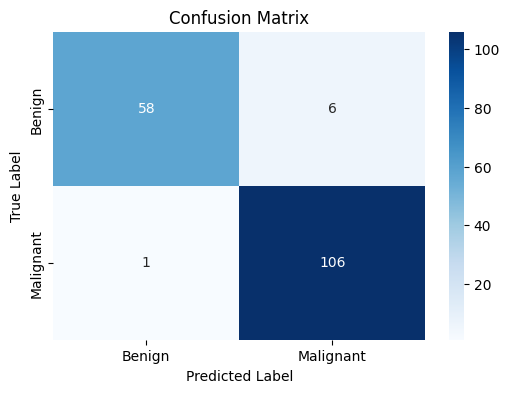

ROC-AUC Score: 0.9863


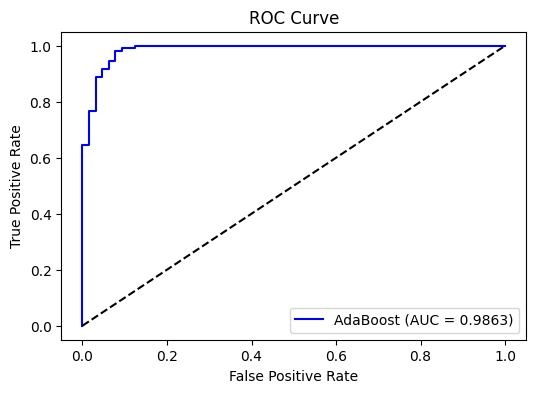

In [6]:
# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"AdaBoost Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'AdaBoost (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:05<00:00,  1.85s/it]


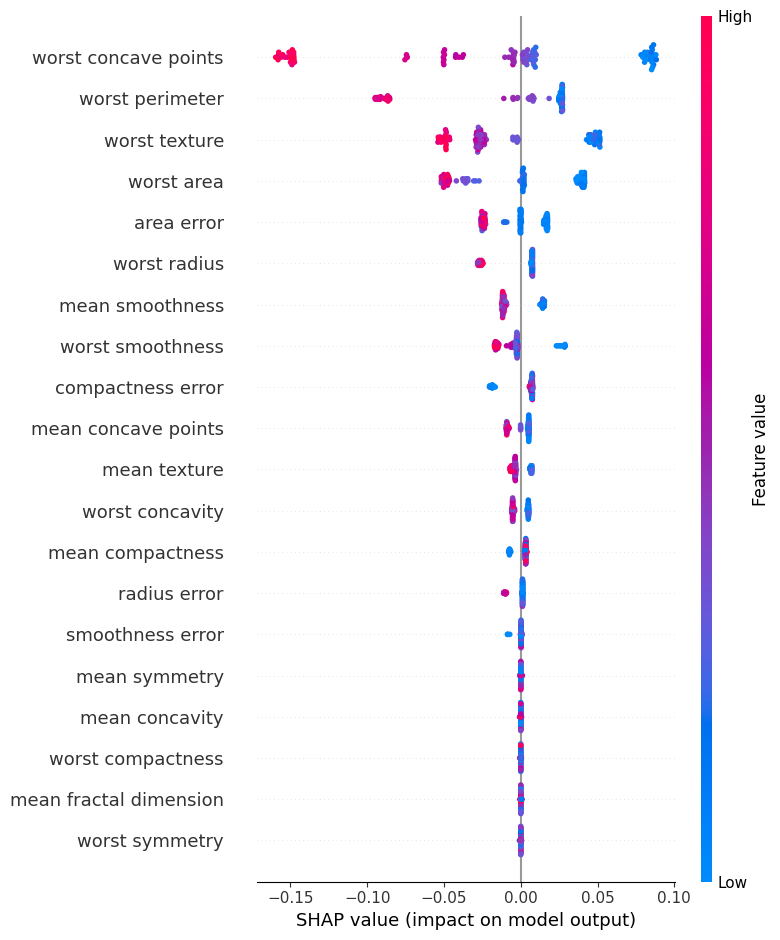

In [9]:
import shap

# Use a small sample of the dataset for efficiency
X_sample = X_train[:50]  

# Create KernelExplainer
explainer = shap.KernelExplainer(adaboost.predict_proba, X_sample)

# Compute SHAP values (for class 1 probabilities)
shap_values = explainer.shap_values(X_test[:100])  # Using a subset for faster computation

# Summary plot
shap.summary_plot(shap_values[1], X_test[:100], feature_names=data.feature_names)


In [10]:

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'base_estimator__max_depth': [1, 2, 3]  # Tuning the weak learner
}

# Initialize Grid Search
grid_search = GridSearchCV(AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate best model
best_model = grid_search.best_estimator_
best_predictions = best_model.predict(X_test)
best_accuracy = accuracy_score(y_test, best_predictions)
print(f"Best AdaBoost Model Accuracy: {best_accuracy:.4f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits


`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Best Parameters: {'base_estimator__max_depth': 1, 'learning_rate': 1.0, 'n_estimators': 200}
Best AdaBoost Model Accuracy: 0.9649
